In [ ]:
%matplotlib inline
import os
import sys
from functools import partial

import torch
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from open_clip import create_model_and_transforms, get_tokenizer

import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

from dataset import PartImageNetWithMask, PredictedMask
from utils import TextFeatures, get_masked_pred_sam_c, get_masked_pred_sam_f
from utils import create_colormap, visualize_img, visualize_seg

/home/swmo/.conda/envs/cast/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0"
torch.cuda.set_device(device)

clip, _, clip_transform = create_model_and_transforms('ViT-B-16', pretrained='openai')
tokenizer = get_tokenizer('ViT-B-16')

clip = clip.to(device)

normalize = clip_transform.transforms[-1]
img_transform = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop([224, 224]),
])
seg_transform = T.Compose([
    T.Resize(224, interpolation=InterpolationMode.NEAREST),
    T.CenterCrop([224, 224]),
])

In [3]:
# SAM_MODEL = "vit_b"
# SAM_CKPT_PATH = os.path.join('../sam_ckpt', 'sam_vit_b_01ec64.pth')
SAM_MODEL = "vit_h"
SAM_CKPT_PATH = os.path.join('../sam_ckpt', 'sam_vit_h_4b8939.pth')

sam = sam_model_registry[SAM_MODEL](checkpoint=SAM_CKPT_PATH)
sam.to(device=device)

predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
DATA_ROOT = '../data/PartImageNet/'
SAVE_ROOT = '../pred_segs/'

img_root = os.path.join(DATA_ROOT, 'images/val')
ano_root = os.path.join(DATA_ROOT, 'annotations/val.json')

# Output: image, seg_c, seg_f
dataset = PartImageNetWithMask(img_root, ano_root, img_transform, seg_transform)  # use base image transform

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [5]:
print(dataset.classname_c)
print(dataset.classname_f)

text_features = TextFeatures(clip, tokenizer, dataset.classname_c, dataset.classname_f)

names = {}
for c in dataset.classname_c:
    names[c] = [f for f in dataset.classname_f if c in f]
cmap_c, cmap_f = create_colormap(names)

['Quadruped', 'Biped', 'Fish', 'Bird', 'Snake', 'Reptile', 'Car', 'Bicycle', 'Boat', 'Aeroplane', 'Bottle']
['Quadruped Head', 'Quadruped Body', 'Quadruped Foot', 'Quadruped Tail', 'Biped Head', 'Biped Body', 'Biped Hand', 'Biped Foot', 'Biped Tail', 'Fish Head', 'Fish Body', 'Fish Fin', 'Fish Tail', 'Bird Head', 'Bird Body', 'Bird Wing', 'Bird Foot', 'Bird Tail', 'Snake Head', 'Snake Body', 'Reptile Head', 'Reptile Body', 'Reptile Foot', 'Reptile Tail', 'Car Body', 'Car Tier', 'Car Side Mirror', 'Bicycle Body', 'Bicycle Head', 'Bicycle Seat', 'Bicycle Tier', 'Boat Body', 'Boat Sail', 'Aeroplane Head', 'Aeroplane Body', 'Aeroplane Engine', 'Aeroplane Wing', 'Aeroplane Tail', 'Bottle Mouth', 'Bottle Body']


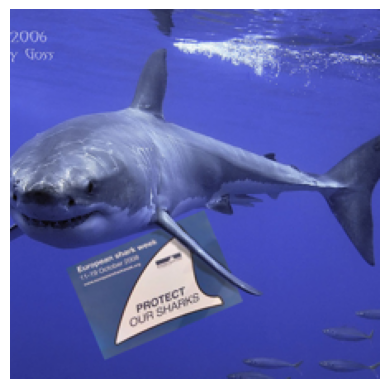

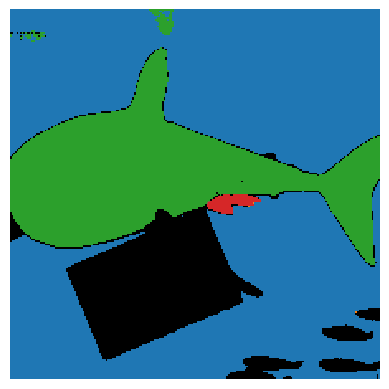

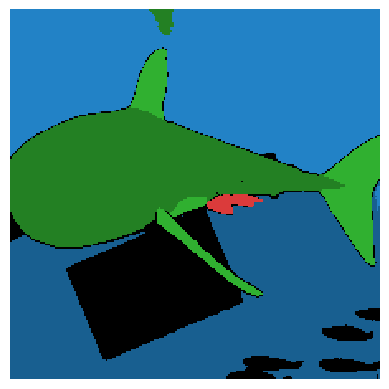

In [6]:
index = 1300

img_base = dataset[index][0]
img = clip_transform(img_base)

masks = mask_generator.generate(np.array(img_base))
masks = sorted(masks, key=lambda m: m["area"], reverse=True)
masks = [torch.from_numpy(m['segmentation']).unsqueeze(0) for m in masks]
mask_c = mask_f = masks

pred_c = get_masked_pred_sam_c(clip, text_features, img, mask_c)
pred_f = get_masked_pred_sam_f(clip, text_features, img, mask_f, pred_c)

visualize_img(img, normalize)
visualize_seg(pred_c, cmap_c)
visualize_seg(pred_f, cmap_f)